In [1]:
import os
if os.getcwd().split("/")[-1] == "notebooks":
    os.chdir(os.pardir)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from scipy.io import loadmat
import scipy.spatial

from pycbem.field import efield, hfield, poynting
from pycbem.utils.dataloader import (load_antenna_el_properties,
                                     load_sphere_coords)
from pycbem.utils.viz import fig_config

In [2]:
jax.config.update("jax_enable_x64", True)

In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
# frequency
f = 10e9

# effective radiated skin area
target_area = (2 / 100, 2 / 100)
A = target_area[0] * target_area[1]
d = -5 / 1000  # distance from the antenna
target_area_origin = (-target_area[0]/2, -target_area[1]/2)

# human head -- homogenous sphere model
r_c = load_sphere_coords(2312)

# antenna electric properties (Poljak 2005)
antenna_data = load_antenna_el_properties(f)
Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
xs = antenna_data.x.to_numpy()
xs = xs - xs.max() / 2
ys = np.zeros_like(xs) + r_c['y'].min() + d
zs = np.zeros_like(xs)

In [5]:
# E field
E = r_c.apply(
    lambda row: efield(row['x'], row['y'], row['z'], xs, ys, zs, Is, f),
    axis=1, result_type='expand')
E.columns = ['Ex', 'Ey', 'Ez']
E_abs = E.apply(
    lambda row: np.sqrt(row['Ex'] ** 2 + row['Ey'] ** 2 + row['Ez'] ** 2),
    axis=1)
E.loc[:, 'E_abs'] = E_abs

# H field
H = r_c.apply(
    lambda row: hfield(row['x'], row['y'], row['z'], xs, ys, zs, Is, f),
    axis=1, result_type='expand')
H.columns = ['Hx', 'Hy', 'Hz']
H_abs = H.apply(
    lambda row: np.sqrt(row['Hx'] ** 2 + row['Hy'] ** 2 + row['Hz'] ** 2),
    axis=1)
H.loc[:, 'H_abs'] = H_abs

# update dataframe
r_c_calc = pd.concat([r_c, E, H], axis=1)

# power density
def _pd(row):
    return (row['Ey'] * row['Hz'].conjugate()
            - row['Ez'] * row['Hy'].conjugate(),
            row['Ex'] * row['Hz'].conjugate(),
            row['Ex'] * row['Hy'].conjugate())

S = r_c_calc.apply(_pd, axis=1, result_type='expand')
S.columns = ['Sx', 'Sy', 'Sz']
S_abs = S.apply(
    lambda row: np.sqrt(row['Sx'] ** 2 + row['Sy'] ** 2 + row['Sz'] ** 2),
    axis=1)
S.loc[:, 'S_abs'] = S_abs 

# update dataframe
r_c_calc = pd.concat([r_c_calc, S], axis=1)

# effective area
r_c_calc_ta = r_c_calc[
    (r_c_calc['y'] < 0) &
    (r_c_calc['x'] > target_area_origin[0]) &
    (r_c_calc['x'] < target_area_origin[0] * -1) &
    (r_c_calc['z'] > target_area_origin[1]) &
    (r_c_calc['z'] < target_area_origin[1] * -1)]
r_c_calc_ta.reset_index(drop=True, inplace=True)

In [6]:
hull = scipy.spatial.ConvexHull(r_c_calc[['x', 'y', 'z']].to_numpy())
triangle_coords = hull.points[hull.simplices]

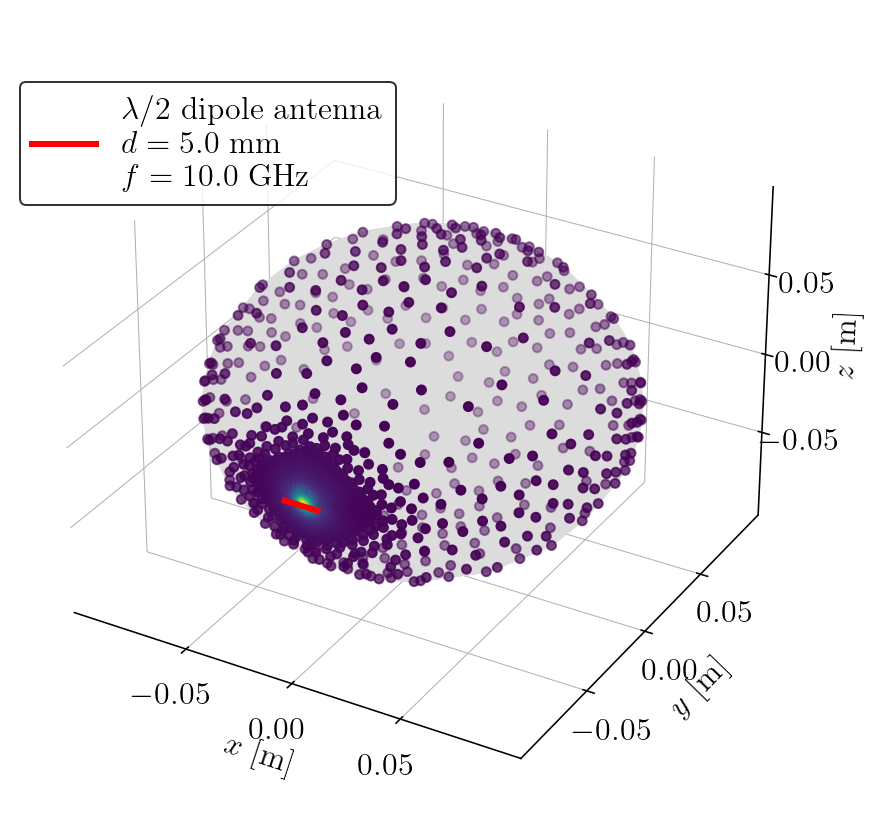

In [7]:
fig_config(latex=True, scaler=2.5)
fig = plt.figure(figsize=(7, 6))
ax = plt.axes(projection ='3d')

ax.add_collection3d(Poly3DCollection(triangle_coords, color='gainsboro'))
cs = ax.scatter(r_c_calc['x'], r_c_calc['y'], r_c_calc['z'],
                c=np.abs(r_c_calc['S_abs']))
#cbar = fig.colorbar(cs, ax=ax)
#cbar.ax.set_ylabel('$S$ [W/m$^2$]')

ax.plot(xs, ys, zs, linestyle='-', c='r', zorder=4,
        label=(f'$\\lambda/2$ dipole antenna\n'
               f'$d = {-d * 1000}$ mm\n'
               f'$f = {f / 1e9}$ GHz'))

ax.set(xlabel='$x$ [m]', ylabel='$y$ [m]', zlabel='$z$ [m]',
       xticks=[-0.05, 0.0, 0.05],
       yticks=[-0.05, 0.0, 0.05],
       zticks=[-0.05, 0.0, 0.05])
ax.set_xlim3d(-0.1, 0.1)
ax.set_ylim3d(-0.1, 0.1)
ax.set_zlim3d(-0.1, 0.1)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

fig.legend(bbox_to_anchor=(0.5, 0.9), ncol=1, frameon=True, edgecolor='k')
plt.tight_layout()
plt.show()

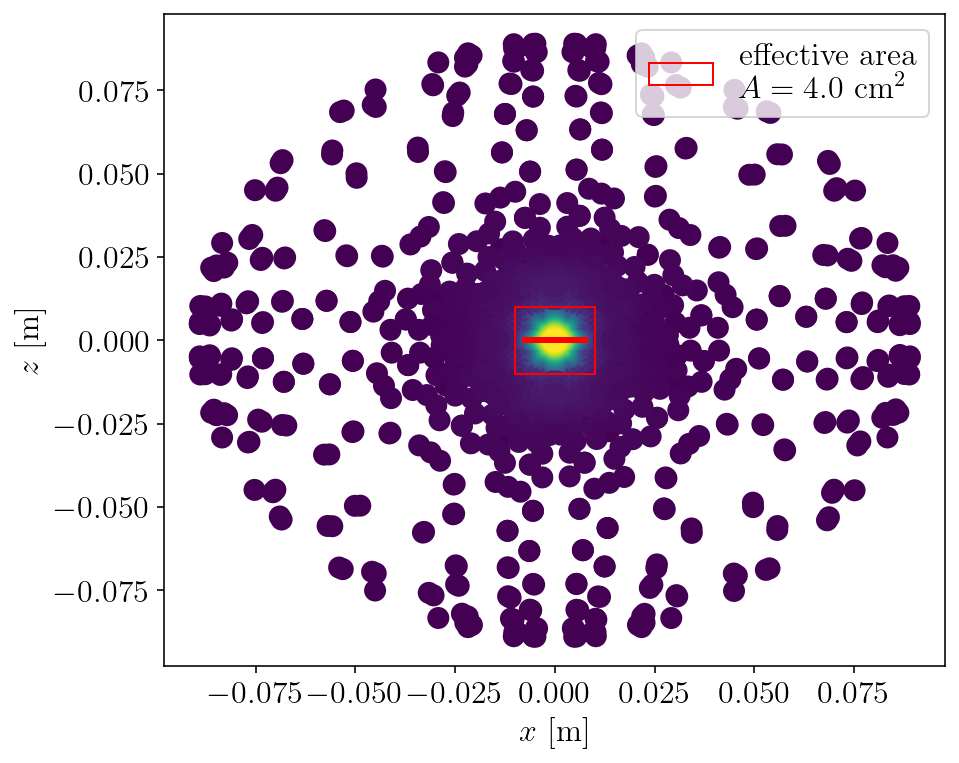

In [8]:
fig_config(latex=True)
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot()
cs = ax.scatter(r_c_calc['x'], r_c_calc['z'], c=np.abs(r_c_calc['S_abs']))
ax.plot(xs, zs, linestyle='-', c='r')
ax.add_patch(Rectangle(target_area_origin, target_area[0], target_area[1],
                       ec='r', fc='None',
                       label=f'effective area\n$A = {A * 1e4}$ cm$^2$'))
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$z$ [m]')
ax.legend()
plt.show()

In [9]:
from scipy.special import roots_legendre


def cart2sph(x, y, z):
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    return (r, theta, phi)


def sph2cart(r, theta, phi):
    x = r * np.cos(phi) * np.sin(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(theta)
    return (x, y, z)

In [10]:
x, y, z = r_c_calc_ta['x'].copy().to_numpy(), r_c_calc_ta['y'].copy().to_numpy(), r_c_calc_ta['z'].copy().to_numpy()
_, theta, phi = cart2sph(x, y, z)
theta_a = theta.min()
theta_b = theta.max()
phi_a = phi.min()
phi_b = phi.max()
x_theta, w_theta = roots_legendre(33)
x_phi, w_phi = roots_legendre(33)
x_theta = 0.5 * (x_theta + 1.) * (theta_b - theta_a) + theta_a
w_theta = 0.5 * w_theta * (theta_b - theta_a)
x_phi = 0.5 * (x_phi + 1.) * (phi_b - phi_a) + phi_a
w_phi = 0.5 * w_phi * (phi_b - phi_a)

r = 0.09
xt_list, yt_list, zt_list = [], [], []
poynting_mag = 0
S_list = []
for _theta, _w_theta in zip(x_theta, w_theta):
    for _phi, _w_phi in zip(x_phi, w_phi):
        xt, yt, zt = sph2cart(r, _phi, _theta)
        xt_list.append(xt)
        yt_list.append(yt)
        zt_list.append(zt)
        Sx, Sy, Sz = poynting(xt, yt, zt, xs, ys, zs, Is, f)
        S = np.sqrt(Sx ** 2 + Sy ** 2 + Sz ** 2)
        S_list.append(S)
        poynting_mag +=  np.real(S) * _w_phi * _w_theta * np.sin(_theta) * r ** 2
Sab = poynting_mag / (2 * A)

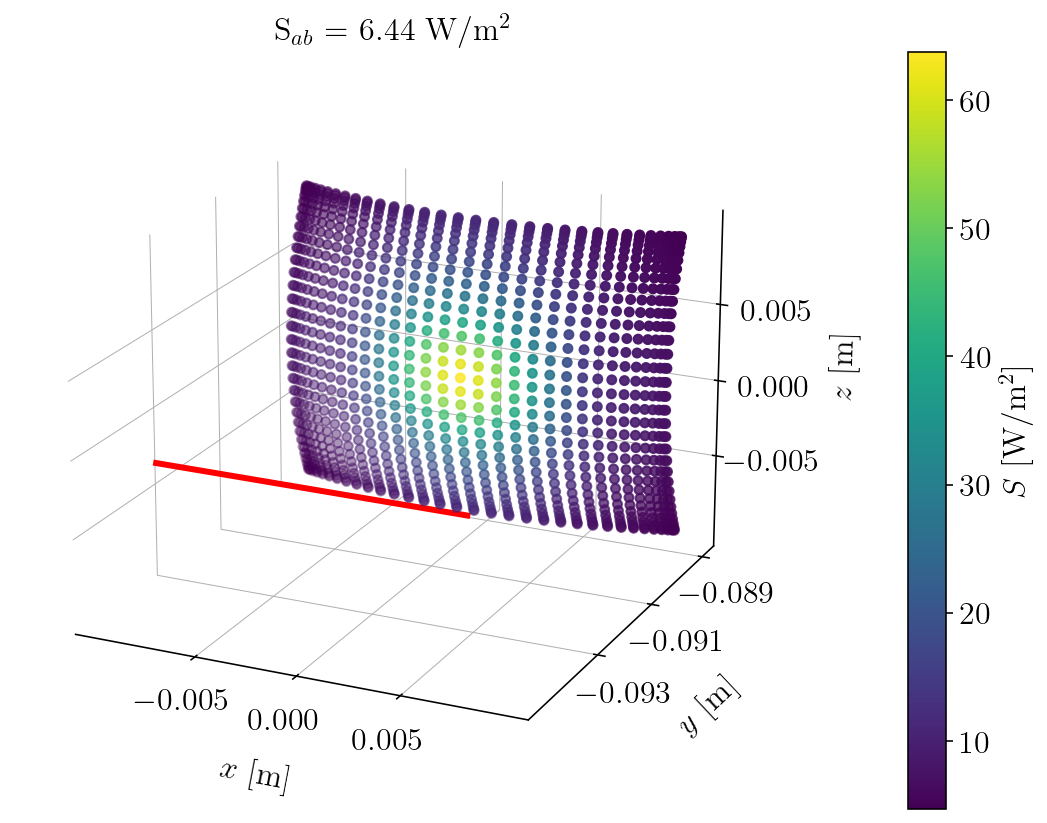

In [11]:
fig_config(latex=True, scaler=2.5)
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection ='3d')

cs = ax.scatter(xt_list, yt_list, zt_list, c=np.abs(S_list))
cbar = fig.colorbar(cs, pad=0.1)
cbar.ax.set_ylabel('$S$ [W/m$^2$]')
ax.plot(xs, ys, zs, linestyle='-', c='r', zorder=1)
ax.set(xlabel='$x$ [m]', ylabel='$y$ [m]', zlabel='$z$ [m]',
       title=f'S$_{{ab}}$ = {Sab:.2f} W/m$^2$',
       xticks=[-0.005, 0.0, 0.005],
       yticks=[-0.093, -0.091, -0.089],
       zticks=[-0.005, 0.0, 0.005])
ax.tick_params(axis='z', which='major', pad=10)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 20
ax.view_init(20, -65)

plt.tight_layout()
plt.show()